# Network of Genres

Clusters similar genres together.

In [1]:
from community import best_partition, modularity
import numpy as np
import pandas as pd
import networkx as nx
import collections as clt
import matplotlib.pyplot as plt
import pickle
import itertools
from joblib import Parallel, delayed
import math

In [2]:
df = pd.read_csv('reviews_full_v7.csv')

In [3]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [4]:
G = nx.Graph()
B = nx.Graph()

In [5]:
#construction of bipartite graph
genres = set()
users = set()
posScore = 75
def isNaN(x):
    return x != x
for index,row in df.iterrows():
    if row['Score'] < posScore: #removing reviews with low score 
        continue
    if isNaN(row['Combined_Genre']):
        continue
    genre_list = row['Combined_Genre'].split('|')
    user = row['User']
    users.add(user)
    for genre in genre_list:
        genres.add(genre)
        if B.has_edge(user,genre):
            B[user][genre]['weight'] += 1
        else:
            B.add_edge(user, genre, weight = 1)

In [6]:
B.number_of_nodes(), B.number_of_edges()

(8344, 33217)

[51, 51, 53, 53, 54, 54, 54, 55, 55, 58, 60, 61, 61, 62, 62, 63, 64, 66, 67, 70, 72, 72, 75, 77, 81, 82, 82, 84, 125, 131]


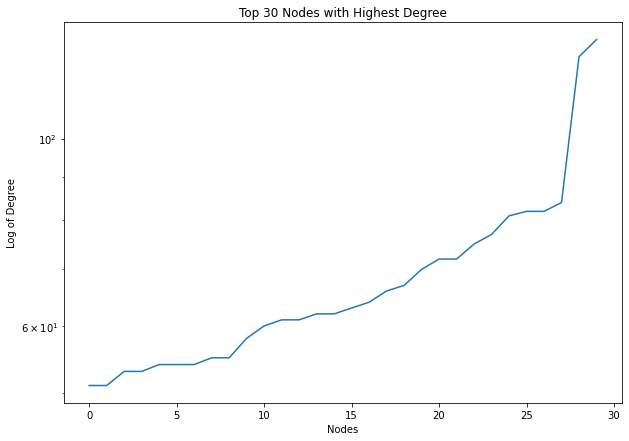

In [7]:
plt.title('Top 30 Nodes with Highest Degree')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
plt.semilogy(sorted([B.degree[user] for user in users])[-30:])
print(sorted([B.degree[user] for user in users])[-30:])
plt.show()

In [8]:
#removing structural holes
for user in users.copy():
    if B.degree[user] > 100:
        B.remove_node(user)
        print(user)
        users.remove(user)

hells_unicorn
autothrall


In [9]:
G = nx.Graph()
for genre1 in genres:
    if genre1 not in B.nodes():
        continue
    for user in B.adj[genre1]:
        w = B[genre1][user]['weight']
        for genre2 in B.adj[user]:
            #the weight of the edge is determined as the minimum weights of the two edges in bipartite graph
            #weights are double counted
            if genre2 >= genre1:
                continue
            w = min(w,B[genre2][user]['weight'])
            if G.has_edge(genre1,genre2):
                #G[genre1][genre2]['weight'] += w
                G[genre1][genre2]['weight'] += 1
            else:
                #G.add_edge(genre1, genre2, weight = w)
                G.add_edge(genre1, genre2, weight = 1)

In [10]:
G.number_of_nodes(), G.number_of_edges()

(289, 18130)

In [11]:
#calculating similarity between two nodes which share an edge (else default is zero).
#By using each edge, this method cuts down time complexity from O(N^2) to O(E)
def calc_sim(Graph):
    for u,v in Graph.edges():
        #similarity = 2*overlap/sum of degrees of u and v
        sum_of_degrees = Graph.degree(u,weight = 'weight')+Graph.degree(v,weight = 'weight')
        common_edges = Graph[u][v]['weight']
        Graph[u][v]['similarity'] = (2*common_edges)/sum_of_degrees #is this the best way?
        #G[u][v]['similarity'] = common_edges/(sum_of_degrees - common_edges)
    return Graph

In [12]:
G = calc_sim(G)

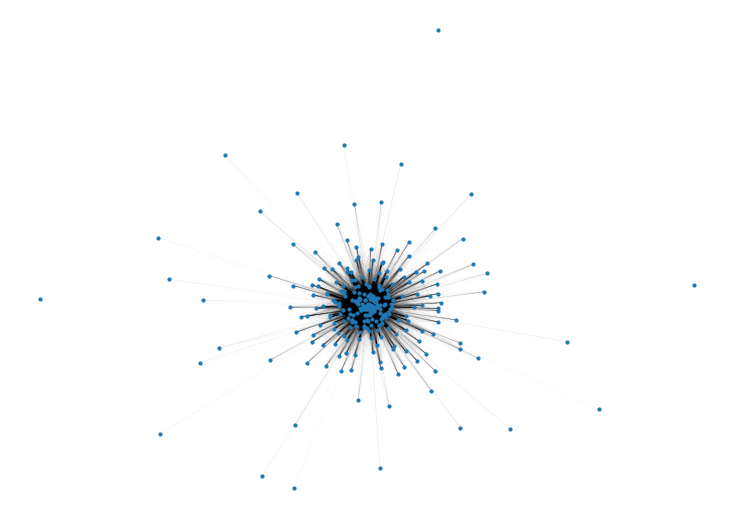

In [13]:
weights = np.array(list(nx.get_edge_attributes(G,'weight').values()))/100
nx.draw(G, node_size = 10, width = list(weights))

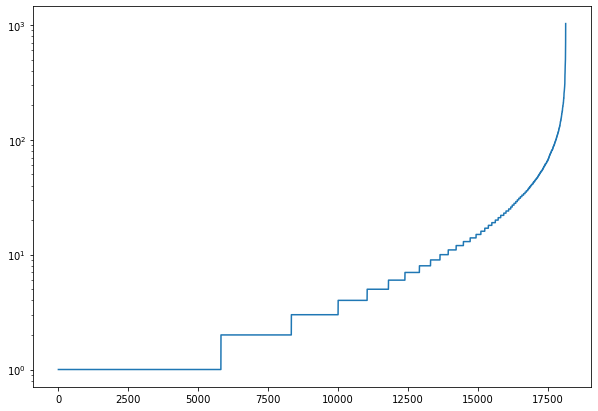

In [14]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))

In [15]:
def fragment(inp):
    inp = sorted(inp)
    total = sum(inp)
    return -1*sum([(x/total)*math.log(x/total) for x in inp])

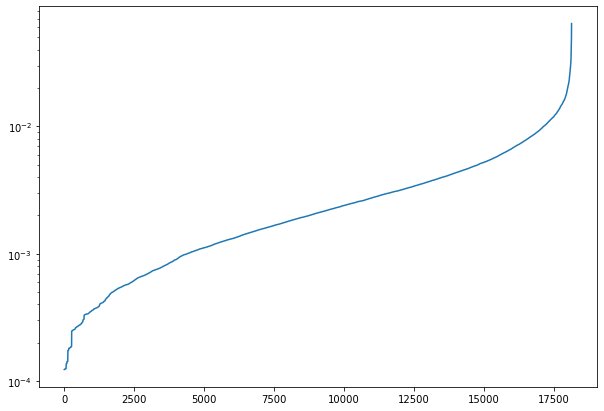

In [16]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'similarity').values())))
plt.show()

In [17]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'similarity').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

In [18]:
genre_group = pickle.load(open('genre_group.p','rb'))
print(G.number_of_nodes())
G2 = G.copy()
for node in G2.nodes():
    #if node not in genre_group:
        #print(node)
    if node not in genre_group or genre_group[node] == 'Non-metal' or genre_group[node] == 'Others':
        G.remove_node(node)
print(G.number_of_nodes())

289
188


In [19]:
G3 = G.copy()

In [20]:
#Calculating betweenness values for edges
bb = nx.edge_betweenness_centrality(G, normalized=True)
nx.set_edge_attributes(G, bb, 'betweenness')
for u,v in G.edges:
    G[u][v]['width'] = (1 - G[u][v]['betweenness']) #larger betweenness, more likely to be eliminated, hence lower width

tmp = list(nx.get_edge_attributes(G,'width').values())
maxi, mini = max(tmp), min(tmp)
print(maxi,mini)

G2 = G.copy()

for u,v in G2.edges:
    G[u][v]['width'] = ((G2[u][v]['width']-mini + 1)/(maxi-mini))*G2[u][v]['weight'] #width = (1-betweenness)*weight

0.999943110706565 0.9893617021276596


In [21]:
#Thresholding
G2 = G.copy()
print(list(nx.isolates(G)))

for u,v in G2.edges():
    if G2[u][v]['width'] < 100: 
        G.remove_edge(u,v)
        
nx.number_connected_components(G)
print(clt.Counter([len(cc) for cc in nx.connected_components(G)]))
print(list(nx.isolates(G)))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes()

[]
Counter({1: 21, 167: 1})
['modern gothenburg metal', 'blackened grindcore', 'blackened industrial metal', 'experimental thrash metal', 'electronic industrial metal', 'epic black metal', 'atmospheric progressive metal', 'avantgarde industrial metal', 'avantgarde doom metal', 'epic folk', 'gothic death metal', 'blackened gothic metal', 'ambient folk', 'death thrash metal', 'gothic folk metal', 'medieval folk rock', 'industrial gothic metal', 'groove death metal', 'experimental avantgarde metal', 'pagan death metal', 'instrumental power metal']


167

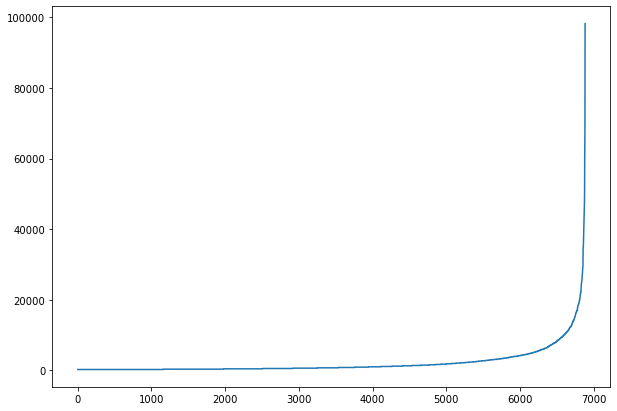

In [22]:
plt.plot(sorted(list(nx.get_edge_attributes(G,'width').values())))

In [23]:
'''tmp = sorted(list(nx.get_edge_attributes(G,'width').values()))
plt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])
plt.show()'''

"tmp = sorted(list(nx.get_edge_attributes(G,'width').values()))\nplt.plot([fragment(tmp[:x+1]) for x in range(len(tmp))])\nplt.show()"

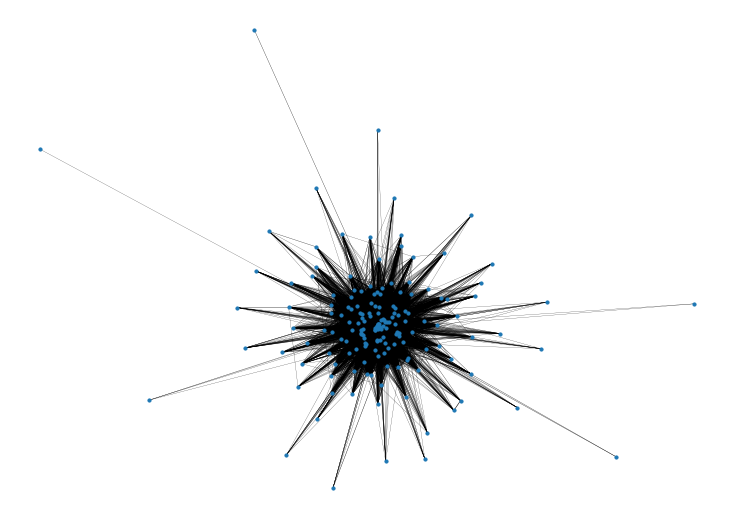

In [24]:
tmp = np.array(list(nx.get_edge_attributes(G,'width').values()))/1000
nx.draw(G, node_size = 10, width = tmp)

In [25]:
genre_group = pickle.load(open('genre_group.p','rb'))
len(genre_group)

298

In [26]:
'''tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]
mp = {}
for genre in tmp:
    for item in genre[1:]:
        mp[item] = genre[0]
pickle.dump(mp,open('genre_group.p','wb'))
f = open('genres.txt').read().split('\n')[:-1]
for item in f:
    if item not in genre_group:
        print(item)'''

"tmp = [item.split(', ')[:-1] for item in open('genre_group.txt').read().split('\n\n')]\nmp = {}\nfor genre in tmp:\n    for item in genre[1:]:\n        mp[item] = genre[0]\npickle.dump(mp,open('genre_group.p','wb'))\nf = open('genres.txt').read().split('\n')[:-1]\nfor item in f:\n    if item not in genre_group:\n        print(item)"

In [27]:
def freq_network_parr(Graph, n_iter, n_jobs, width = 'width', res = 1):#Graph is new frequency network
    partitions = Parallel(n_jobs=n_jobs)(delayed(best_partition)(Graph, randomize = True, weight = width, resolution = res) for i in range(n_iter))
    #partitions = [best_partition(Graph, randomize = True, weight = 'weight') for i in range(n_iter)]
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]))
    print(nx.number_connected_components(Graph), N, len(Graph.edges()))
    prob = {} #key is (node 1, node 2), value is number of times they are in the same cluster/total number of iterations
    total = 0
    G = nx.Graph()
    for partition in partitions:# for n_iter number of iterations
        #partition = best_partition(Graph, randomize = True, weight = 'weight')
        mp = {}
        for user in partition:
            if partition[user] not in mp:
                mp[partition[user]]= []
            mp[partition[user]].append(user)
        for part in mp:
            for u,v in itertools.combinations(mp[part],2):
                if G.has_edge(u,v):
                    G[u][v][width] += 1
                else:
                    G.add_edge(u,v)
                    G[u][v][width] = 1
    N = int(sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(G)]))
    print(nx.number_connected_components(G), N, G.number_of_edges())
    return G

def no_crossedges(Graph):
    return sum([len(cc)*(len(cc)-1)/2 for cc in nx.connected_components(Graph)]) == Graph.number_of_edges()

In [28]:
H = G.copy()
#0.9 is good
H = freq_network_parr(H, 100, 4, res = 0.8)
while not no_crossedges(H):
    H = freq_network_parr(H, 100, 4)

1 13861 6886
1 13861 2895
1 13861 2895
5 7322 2292
5 7322 2292
9 1883 1883


In [29]:
partitions = [cc for cc in nx.connected_components(H)]

In [30]:
def getScore(Graph):#using original graph
    comps = list(nx.connected_components(Graph))
    subgraphs = [G.subgraph(comp) for comp in comps]
    ave_weight = [sum([G[u][v]['weight']/sub.number_of_edges() for u,v in sub.edges()]) for sub in subgraphs]
    ave_cluster_weight = [sum([G[u][v]['weight']/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for u,v in sub.edges()]) for sub in subgraphs]
    density = [sub.number_of_edges()/(sub.number_of_nodes()*(sub.number_of_nodes()-1)/2) for sub in subgraphs]
    return ave_weight, ave_cluster_weight, density
getScore(H)

([9.486880466472327,
  54.60000000000001,
  24.424657534246563,
  44.528735632183896,
  18.90680100755662,
  19.985915492957762,
  14.01052631578947,
  17.79629629629629,
  109.125],
 [6.162878787878806,
  54.60000000000001,
  13.11029411764706,
  20.389473684210518,
  11.270270270270316,
  13.51428571428571,
  11.09166666666667,
  12.320512820512816,
  58.2],
 [0.6496212121212122,
  1.0,
  0.5367647058823529,
  0.45789473684210524,
  0.5960960960960962,
  0.6761904761904762,
  0.7916666666666666,
  0.6923076923076923,
  0.5333333333333333])

In [31]:
[len(cc) for cc in partitions]

[33, 6, 17, 20, 37, 15, 16, 13, 10]

In [32]:
def genData(Graph, ind):
    ret = pd.DataFrame()
    ret['Genres'] = list(nx.connected_components(Graph))
    ret['Sizes'] = [len(cc) for cc in nx.connected_components(Graph)]
    ret['Average_Weight'], ret['Average_Weight_by_Nodes'], ret['Cluster_Density'] = getScore(Graph)
    ret.to_csv('round'+str(ind)+'_genre.csv', index = False)
    return ret
genData(H,1)

,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density
0,"{new wave of british heavy metal, industrial p...",33,9.486880,6.162879,0.649621
1,"{metalcore, melodic death metal, melodic metal...",6,54.600000,54.600000,1.000000
2,"{brutal deathcore, progressive death metal, in...",17,24.424658,13.110294,0.536765
3,"{us power metal, technical progressive metal, ...",20,44.528736,20.389474,0.457895
4,"{atmospheric black metal, blackened sludge met...",37,18.906801,11.270270,0.596096
5,"{pagan folk metal, pagan black metal, symphoni...",15,19.985915,13.514286,0.676190
6,"{blackened speed metal, black doom metal, blac...",16,14.010526,11.091667,0.791667
7,"{gothic metal, extreme gothic metal, gothic in...",13,17.796296,12.320513,0.692308
8,"{blackened stoner metal, progressive doom meta...",10,109.125000,58.200000,0.533333


In [33]:
from IPython.display import display, HTML
def breakDown(inds):
    for ind in inds:
        G1 = G.subgraph(list(nx.connected_components(H))[ind])
        while not no_crossedges(G1):
            G1 = freq_network_parr(G1, 100, 4)
        print('End Clustering: ',ind)
        display(genData(G1,'2-'+ str(ind)))

In [35]:
#breakDown([0,4])

1 528 343
2 466 318
2 466 318
4 150 150
End Clustering:  0


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density
0,"{progressive thrash metal, melodic progressive...",8,9.176471,5.571429,0.607143
1,"{new wave of british heavy metal, us industria...",12,12.321429,10.454545,0.848485
2,"{progressive math metal, djent}",2,12.000000,12.000000,1.000000
3,"{industrial metal, industrial progressive meta...",11,9.439024,7.036364,0.745455


1 666 397
1 666 456
1 666 456
1 666 370
1 666 370
2 366 366
End Clustering:  4


,Genres,Sizes,Average_Weight,Average_Weight_by_Nodes,Cluster_Density
0,"{ambient doom metal, drone doom metal, blacken...",12,30.893617,22.00,0.712121
1,"{atmospheric black metal, experimental progres...",25,15.066298,9.09,0.603333
